## Building CNN The Right Way

This assignment focusses on use concepts in the right way to build a good Convolutional Neural Network

### Import necessary modules

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 

from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

In [3]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 4s 0us/step


#### Visualzing dataset

* Its very important to visualize that dataset to understand the complexity of features the network should learn
* It also helps in understanding what sort of image augmentation should be applied to the datasets

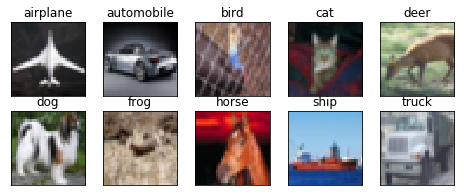

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

#### Helper functions

* Following are helper functions to understand how network performed
* It plots graph on model accuracy and loss for training vs validation dataset over increasing epochs

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

#### Pixel Normalization

* It is good to rescale dataset, so that network sees image in same range and hence makes it easy to learn

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

#### Network architecure 

We design the network by making the following considerations:
  * No Dropout in last layer
  * Remove Dense layers
  * Have network with alternating high channels & low channels (squeeze & excite)
  * Add Batch Normalization
  * Add Image Normalization
  * Add Image Augmentation

In [8]:
# Define the model

dropout_val = 0.1
conv_start_size = 64

def Conv_Block(model, num_channels):
  model.add(Convolution2D(num_channels, 3, 3, border_mode='same')) 
  model.add(BatchNormalization())
  model.add(Activation('relu')) 
  model.add(Dropout(dropout_val))
  model.add(Convolution2D(2*num_channels, 3, 3, border_mode='same')) 
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(dropout_val))
  
def Transition_Block(model, num_channels):
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Convolution2D(num_channels, 1, 1))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(dropout_val))


model = Sequential()
model.add(Convolution2D(conv_start_size, 3, 3, border_mode='same', input_shape=(32, 32, 3))) # Output: 32x32x64
model.add(BatchNormalization())
model.add(Activation('relu')) 
model.add(Dropout(dropout_val))

Conv_Block(model, conv_start_size) # 32x32x128
Transition_Block(model, conv_start_size) # 16x16x64

Conv_Block(model, conv_start_size) # 16x16x128
Transition_Block(model, conv_start_size) # 8x8x64

Conv_Block(model, conv_start_size) # 8x8x128
Transition_Block(model, conv_start_size) # 4x4x64

Conv_Block(model, conv_start_size) # 4x4x128
Transition_Block(model, conv_start_size) # 2x2x64


model.add(Convolution2D(10, 2, 2)) # Output: 1x1x10

model.add(Flatten())
model.add(Activation('softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



W0627 16:50:46.097524 139826409867136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(32, 32, 3..., padding="same")`
W0627 16:50:46.152966 139826409867136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0627 16:50:46.161937 139826409867136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0627 16:50:46.222211 139826409867136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
__________

#### Run the  network and examine output

* Gives accuracy of 88.4

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

checkpoint = ModelCheckpoint("best_weights.hdf5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1,
                                 callbacks=[checkpoint])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=100)`
W0627 16:31:18.061999 140097105184640 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a futur

Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


390/390 [==============================] - 69s 176ms/step - loss: 1.6283 - acc: 0.4021 - val_loss: 1.8976 - val_acc: 0.3526

Epoch 00001: val_acc improved from -inf to 0.35260, saving model to best_weights.hdf5
Epoch 2/100
390/390 [==============================] - 62s 159ms/step - loss: 1.2396 - acc: 0.5521 - val_loss: 1.9739 - val_acc: 0.3619

Epoch 00002: val_acc improved from 0.35260 to 0.36190, saving model to best_weights.hdf5
Epoch 3/100
390/390 [==============================] - 61s 158ms/step - loss: 1.0194 - acc: 0.6383 - val_loss: 1.0404 - val_acc: 0.6182

Epoch 00003: val_acc improved from 0.36190 to 0.61820, saving model to best_weights.hdf5
Epoch 4/100
390/390 [==============================] - 61s 157ms/step - loss: 0.8595 - acc: 0.6949 - val_loss: 0.9180 - val_acc: 0.6700

Epoch 00004: val_acc improved from 0.61820 to 0.67000, saving model to best_weights.hdf5
Epoch 5/100
390/390 [==============================] - 61s 158ms/step - loss: 0.7671 - acc: 0.7296 - val_loss: 

### Save model to GDrive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')



!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

weights_file = drive.CreateFile({'title' : 'assignment-9-weights.hdf5'})
weights_file.SetContentFile('best_weights.hdf5')
weights_file.Upload()
drive.CreateFile({'id': weights_file.get('id')})

# 3. reload weights from google drive into the model

# use (get shareable link) to get file id
# last_weight_file = drive.CreateFile({'id': '1sj...'}) 
# last_weight_file.GetContentFile('last_weights.mat')
# model.load_weights('last_weights.mat')

### gradCAM to visualize Class Activation Maps

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline

fig=plt.figure(figsize=(18, 18))
columns = 2
rows = 4
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

# Pick 4 images from a random start index
img_id = np.random.randint(train_features.shape[0]- (columns * rows))

i = 0
imgCnt = 0
while i < columns*rows:
    fig.add_subplot(rows, columns, i+1)
    index = img_id + imgCnt
    imgCnt += 1
    x = train_features[index]
    print(x.shape)
    preds = model.predict(x.reshape(1, 32, 32, 3)) #x.shape[0], x.shape[1]), x.shape[2])
    class_idx = np.argmax(preds[0])
    class_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer("conv2d_13") # 2x2x64
    
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for ii in range(64):
        conv_layer_output_value[:, :, ii] *= pooled_grads_value[ii]

        
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    img = x
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    plt.imshow(x)
    
    i += 1
    fig.add_subplot(rows, columns, i+1)
    #cv2.imshow("GradCam", superimposed_img)
    i += 1
    
    annotation = "Img #: " + str(index)
    #annotation = "Actual: %d, Predicted: %d" % (Y_test_actual[index], Y_pred_actual[index])
    plt.annotate(annotation, xy=(0,0), xytext=(0,-1.2), fontsize=13)
plt.show()